In [29]:
using LinearAlgebra
using DynamicPolynomials
using SpecialFunctions
using TSSOS
using HomotopyContinuation

using QuantumOptics
using QuadGK
using JuMP
using Random
using NLopt

In [30]:
# the initial condition
vecC0 = [0; 1; 0; 0;   2; 0; 0; 0;   0; 0; 0; 0;   0; 0; 1; 0];

# the final condition
vecCf = [0; 0; 0; 0;   1; 0; 0; 0;   0; 0; 0; 1;   0; 0; 2; 0];

In [31]:
# systems parameters
ω = 1.0 #1 // 1
g = 1.0 #1 // 1


H0 = [ω    0      0  0;
          0    -ω     0  0;
         0 0  ω      0;
          0 0   0     -ω]

    
Hc =   im * [0    0      -g  -g;
          0    0     g  g;
         -g -g  0      0;
          g g   0     0]

4×4 Matrix{ComplexF64}:
  0.0+0.0im   0.0+0.0im  -0.0-1.0im  -0.0-1.0im
  0.0+0.0im   0.0+0.0im   0.0+1.0im   0.0+1.0im
 -0.0-1.0im  -0.0-1.0im   0.0+0.0im   0.0+0.0im
  0.0+1.0im   0.0+1.0im   0.0+0.0im   0.0+0.0im

In [32]:
Ut = [ 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0;
    0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0;
    0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0;
    0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0;
    0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0;
    0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1;
    0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0;
    0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0;
    0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0;
    0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0;
    1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;
    0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0;
    0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0;
    0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0;
    0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0;
    0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]

16×16 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0

In [33]:
function ∫(p::AbstractPolynomial, x::PolyVar, x_lower, x_upper)
    
    # get the index of the variable of integration
    ind_x = indexin([x], variables(p))[1]
        
    if isnothing(ind_x)
        # integration valuable is not found among vars
        return p * (x_upper - x_lower)
    end
    
    # get the indefinite integral
    int_p = sum(
        term * x * 1 // (exponents(term)[ind_x] + 1) for term in terms(p)
        init = 0 * x
    )
            
    # get the definite integral
    subs(int_p, x=>x_upper) - subs(int_p, x=>x_lower)
end

function ∫(M::AbstractMatrix, x::PolyVar, x_lower, x_upper)
   map(z -> ∫(z, x, x_lower, x_upper), M) 
end

function real_poly(p::Polynomial)
    #=
    Real part of the polynomial
    =#
    sum(
        real(c) * m for (c, m) in zip(coefficients(p), monomials(p))# if ~isapproxzero(abs(c))
    )
end

function square_frobenius_norm(M::AbstractArray)
    #=
    Square of the Frobenius norm of a matrix
    =#
    real_poly(sum(z' * z for z in M))
end

function square_norm(x)

    real_poly(x' * x)
    
end

function err_fidelity(A,B)
    1-tr(A'*B)
end

err_fidelity (generic function with 1 method)

In [78]:
@polyvar x[1:1]
@polyvar t[1:3]



function u(t, x)
    # the polynomial shape for control
    sum(x[n] * t^(n - 1) for n = 1:length(x))
end

function A(t, x)
    #=
    The generator of motion entering the Magnus expansion
    =#
    s = size(H0 + Hc * u(t, x))
    kron(H0 + Hc * u(t, x), Matrix(I, s)) + kron(Matrix(I, s), H0 + Hc * u(t, x))
end

function commutator(a, b)
    a * b - b * a
end 

function Magnus(T)

    # get the partial sum of the Magnus expansion
    A₁ = A(t[1], x)
    A₂ = A(t[2], x)
    
    Ω = ∫(A₁, t[1], 0, T);
    
    # 2nd term in the Magnus expansion
    Ω .+= 1//2 * ∫(∫(
        commutator(A₁, A₂), 
        t[2], 0, t[1]), 
        t[1], 0, T
    );
    
    # 3nd term in the Magnus expansion
    
    A₃ = A(t[3], x)
    
    Ω .+= 1//6 * ∫(∫(∫(
        commutator(A₁, commutator(A₂, A₃)) + commutator(commutator(A₁, A₂), A₃),
        t[3], 0, t[2]),
        t[2], 0, t[1]),
        t[1], 0, T
    );

    Ω

end

Magnus (generic function with 1 method)

In [79]:
using SpecialFunctions

"""
Chebyshev approximation for exp(Ω/2)
"""
function exp_chebyshev(Ω::AbstractMatrix, order::Integer)
    
    Tₙ₋₁ = I
    Tₙ  = Ω
    
    # The first two terms of Chebyshev series for exp
    series = besselj(0, 1) * Tₙ₋₁ + 2 * besselj(1, 1) * Tₙ
    
    for n=2:order
        Tₙ₊₁  = 2 * Ω * Tₙ + Tₙ₋₁
        
        series .+= 2 * besselj(n, 1) * Tₙ₊₁
        
        (Tₙ, Tₙ₋₁) = (Tₙ₊₁, Tₙ) 
    end
    
    series
end

exp_chebyshev

In [80]:
using QuantumOptics, LinearAlgebra

function get_unitary(x::AbstractArray,T)
    # Define size of H0 + Hc * u(t, x)
    H_dynamic = H0 + Hc * u(0, x)
    s = size(H_dynamic, 1)  # Extract matrix size

    # Define the Kronecker sum Hamiltonian
    I_s = Matrix(I, s, s)  # Identity matrix of size s
    H_kron = im*(kron(H_dynamic, I_s) + kron(I_s, H_dynamic))

    # Define basis and operators
    basis = NLevelBasis(size(H_kron, 1))
    𝓗ₖ = DenseOperator(basis, basis, H_kron)

    # Define time-dependent Hamiltonian
    function 𝓗(t, psi)
        H_dynamic_t = H0 + Hc * u(t, x)  # Update control term
        H_kron_t = im*(kron(H_dynamic_t, I_s) + kron(I_s, H_dynamic_t))
        𝓗ₖ.data .= H_kron_t  # Update Hamiltonian in place
        return 𝓗ₖ
    end

    # Solve the Schrödinger equation for evolution
    _, 𝓤 = timeevolution.schroedinger_dynamic([0, T], identityoperator(basis, basis), 𝓗)

    return Matrix(𝓤[end].data)  # Return unitary evolution matrix
end


get_unitary (generic function with 1 method)

In [81]:
function log_mat(U)

    F= eigen(U)
    X = F.vectors
    theta_values = [log(λ) for λ in F.values]
    K = Diagonal(theta_values)

    return X*K*inv(X)
    
end

log_mat (generic function with 1 method)

In [82]:
T = 1
Ω = Magnus(T)
Ω = convert(Matrix{Polynomial{true, ComplexF64}}, Ω)
X = exp_chebyshev(Ω,3)
obj =  square_norm((X*vecC0)[2])

0.8449798943677109x₁⁴ + 1.8292720407412704x₁² + 0.9900342663009998

In [83]:
opt,sol,data = tssos_first(obj, variables(obj),order=6;QUIET=true,solution = true);

*********************************** TSSOS ***********************************
TSSOS is launching...
optimum = 0.9900342658232761
Global optimality certified with relative optimality gap 0.000000%!


In [84]:
sol

1-element Vector{Float64}:
 0.0

In [85]:
Z = get_unitary(sol,T)
(Z*vecC0)[2]

1.0 + 0.0im

In [86]:
n = 1000
min_x = zeros(n)
errs = zeros(n)

for i in 1:n
    T = 0.0005*(i)
    Ω = Magnus(T)
    Ω = convert(Matrix{Polynomial{true, ComplexF64}}, Ω)
    X = exp_chebyshev(Ω,3)
    obj =  square_norm((X*vecC0)[2])
    
    # Get the global minimum via TSSOS library
    opt,sol,data = tssos_first(obj, variables(obj), order=10, QUIET=true, solution=true);
    
    previous_sol = sol
    previous_opt = opt
        
        while ~isnothing(sol)
            previous_sol = sol
            previous_opt = opt
                
            opt,sol,data = tssos_higher!(data; QUIET = true, solution = true)
        end
    println(previous_sol)
    min_x[i] = previous_opt
    Z = get_unitary(previous_sol,T)
    errs[i] = abs(real((Z*vecC0)[2]))
end

*********************************** TSSOS ***********************************
TSSOS is launching...
optimum = 0.9900342665395738
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
[0.0]
*********************************** TSSOS ***********************************
TSSOS is launching...
optimum = 0.9900342637899561
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
[0.0]
*********************************** TSSOS ***********************************
TSSOS is launching...
optimum = 0.9900342655443645
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
[0.0]
*********************************** TSSOS ***********************************
TSSOS is launching...
optimum = 0.9900342659978527
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
[0.0]
********************

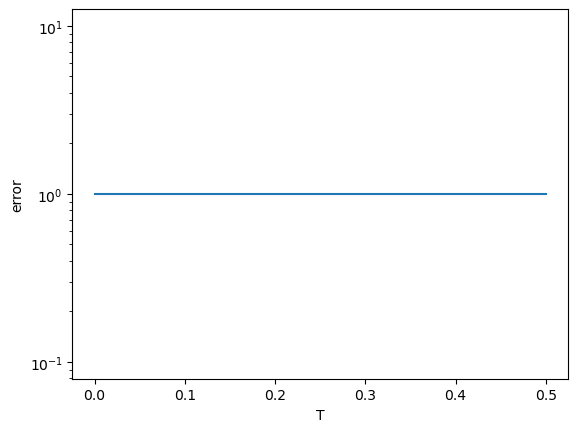

In [87]:
using PyPlot

semilogy([0.0005*(i) for i in 1:n],errs)
xlabel("T")
ylabel("error")
savefig("Optimal_time_1")
show()

In [65]:
0.15

0.15

In [66]:
2*pi/20

0.3141592653589793

In [51]:
T = 0.0005*(300)
Ω = Magnus(T)
Ω = convert(Matrix{Polynomial{true, ComplexF64}}, Ω)
X = exp_chebyshev(Ω,3)
obj =  square_norm((X*vecC0)[2])

f1 = Symbolics.derivative(obj, x[1])
f2 = Symbolics.derivative(obj, x[2])
f3 = Symbolics.derivative(obj, x[3])

result = solve(differentiate.(obj, variables(obj)))
critical_points = real_solutions(result)

LoadError: UndefVarError: `Symbolics` not defined